# Brain Tumour Segmentation in MRI slices

In [4]:
import numpy as np
import math
import random
import os
from PIL import Image
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from keras import backend as K
from sklearn.model_selection import train_test_split

# Build the U-Net model trained by [arashmehrzadi](https://www.kaggle.com/arashmehrzadi) in this [notebook](https://www.kaggle.com/arashmehrzadi/brain-tumor-segmentation-unet)

The code is the cell below is taken from arashmehrzadi's notebook.

In [5]:
def Convolution(input_tensor,filters):
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

def model(input_shape):
    
    inputs = Input((input_shape))
    
    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
    
    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)
    
    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
    upsample_7 = concatenate([upsample_7, conv_3])
    
    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
    upsample_9 = concatenate([upsample_9, conv_1])
    
    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model

In [6]:
input_size = 240
model = model(input_shape = (input_size, input_size, 1))
model.load_weights("../input/brats-model/BraTs2020.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 240, 240, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 240, 240, 32) 128         conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 240, 240, 32) 0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [7]:
path_to_training_studies = "../input/rsna-miccai-png/train/"
training_studies = os.listdir(path_to_training_studies)
random.seed(24)
studies_to_view = random.choices(training_studies, k=3)

In [8]:
def prediction(img_path, save_folder=""):
    '''
    resize the input image and run the prediction
    while removing some noise and saving the mask if required
    '''
    
    test_img = Image.open(img_path)
    resized_img = np.array(test_img.resize((input_size, input_size)))
    
    result = model.predict(np.array([resized_img]))[0].transpose(2,0,1)[0]

    #Remove some of the noise in the predicted mask
    kernel = np.ones((10,10),np.uint8)
    result = cv.morphologyEx(result, cv.MORPH_OPEN, kernel)
    result = np.where(result > 0.9, 1, 0)
    
    if save_folder!="":
        save_path = img_path.replace("../input/rsna-miccai-png", save_folder)
        save_path = save_path.replace(".png","-tumour-mask.png").replace("/T1w","")
        save_folder = save_path.replace(save_path.split("/")[-1],"")
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        
        resized_result = cv.resize(result.astype("float32"), (512,512), interpolation = cv.INTER_AREA)
        cv.imwrite(save_path, resized_result)
    
    return resized_img, result

In [9]:
def find_tumour(study_filename, save_folder="", dataset=path_to_training_studies):
    '''
    Apply the model on all MRI slices and return the 
    slice with the greatest amount of pixels with tumour
    '''
    
    max_detected = 0
    tumour_slice = ""
    MRI_slices = os.listdir("{}{}/T1w/".format(dataset, study_filename))
    
    for MRI_slice_filename in MRI_slices:
        path_to_slice = "{}{}/T1w/{}".format(dataset, study_filename, MRI_slice_filename)
        formatted_img, result = prediction(path_to_slice, save_folder)
        
        tumour_pixel = len(result[result>0.5])
        
        if max_detected < tumour_pixel:
            max_detected = tumour_pixel
            tumour_slice = path_to_slice
    return tumour_slice

def display(img, result):
    plt.imshow(np.squeeze(img),cmap='gray')
    plt.imshow(np.squeeze(result),alpha=0.6,cmap='Reds')
    plt.show()

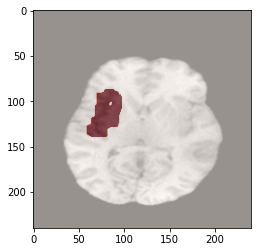

CPU times: user 1min 15s, sys: 989 ms, total: 1min 16s
Wall time: 29 s


In [10]:
%%time
MRI_slice_filename = find_tumour(studies_to_view[0])
img, result = prediction(MRI_slice_filename)
display(img, result)

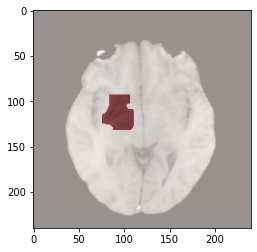

CPU times: user 13.2 s, sys: 114 ms, total: 13.3 s
Wall time: 5.04 s


In [11]:
%%time
MRI_slice_filename = find_tumour(studies_to_view[1])
img, result = prediction(MRI_slice_filename)
display(img, result)

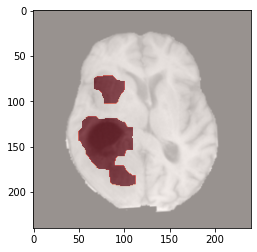

CPU times: user 15.1 s, sys: 139 ms, total: 15.3 s
Wall time: 6.05 s


In [12]:
%%time
MRI_slice_filename = find_tumour(studies_to_view[2])
img, result = prediction(MRI_slice_filename)
display(img, result)